### ============================================
### 02_DATA_CLEANING.ipynb
### ============================================
### Date: 11/02/2026
### Objectif: Nettoyer les données MIMIC-III
### ============================================

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

In [5]:
#======================
# Chargment des données
#======================
print("chargement des données...")
notes=pd.read_csv("/Users/ines/m-dic-AIde/data/raw/NOTEEVENTS_random.csv")
print(f" NOTEEVENTS chargé : {len(notes):,} lignes")
diagnoses=pd.read_csv("/Users/ines/m-dic-AIde/data/raw/DIAGNOSES_ICD_random.csv")
print(f" DIAGNOSES chargé : {len(diagnoses):,} lignes")

print(f"\n AVANT NETTOYAGE :")
print(f"  - Notes : {len(notes):,}")
print(f"  - Colonnes : {notes.shape[1]}")
print(f"  - Patients : {notes['SUBJECT_ID'].nunique():,}")
print(f"  - Hospitalisations : {notes['HADM_ID'].nunique():,}")

chargement des données...
 NOTEEVENTS chargé : 458,090 lignes
 DIAGNOSES chargé : 140,502 lignes

 AVANT NETTOYAGE :
  - Notes : 458,090
  - Colonnes : 11
  - Patients : 10,000
  - Hospitalisations : 12,722


/var/folders/rk/lx_hryp913x75xkqm9xb8fd40000gn/T/ipykernel_82502/504385567.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes=pd.read_csv("/Users/ines/m-dic-AIde/data/raw/NOTEEVENTS_random.csv")


In [6]:
# --------------------------------------------
# 1.2 IDENTIFIER DONNÉES COMMUNES
# --------------------------------------------
print("\n Identification des patients/hospitalisations communs...")

# Patients communs
patients_in_notes = set(notes['SUBJECT_ID'].unique())
patients_in_diagnoses = set(diagnoses['SUBJECT_ID'].unique())
patients_communs = patients_in_notes & patients_in_diagnoses

print(f"  - Patients dans NOTES : {len(patients_in_notes):,}")
print(f"  - Patients dans DIAGNOSES : {len(patients_in_diagnoses):,}")
print(f"  - Patients COMMUNS : {len(patients_communs):,}")

# Hospitalisations communes
hadm_in_notes = set(notes['HADM_ID'].dropna().unique())
hadm_in_diagnoses = set(diagnoses['HADM_ID'].unique())
hadm_communs = hadm_in_notes & hadm_in_diagnoses

print(f"\n  - Hospitalisations dans NOTES : {len(hadm_in_notes):,}")
print(f"  - Hospitalisations dans DIAGNOSES : {len(hadm_in_diagnoses):,}")
print(f"  - Hospitalisations COMMUNES : {len(hadm_communs):,}")


 Identification des patients/hospitalisations communs...
  - Patients dans NOTES : 10,000
  - Patients dans DIAGNOSES : 10,000
  - Patients COMMUNS : 2,145

  - Hospitalisations dans NOTES : 12,722
  - Hospitalisations dans DIAGNOSES : 12,745
  - Hospitalisations COMMUNES : 2,778


In [7]:
# --------------------------------------------
# 1.3 FILTRAGE 1 : PATIENTS ET HOSPITALISATIONS COMMUNS
# --------------------------------------------

print("\n FILTRAGE 1 : Patients et hospitalisations communs...")

notes_filtered = notes[
    (notes['SUBJECT_ID'].isin(patients_communs)) & 
    (notes['HADM_ID'].isin(hadm_communs))
].copy()

print(f" Notes après filtrage communs : {len(notes_filtered):,} ({len(notes_filtered)/len(notes)*100:.1f}%)")


 FILTRAGE 1 : Patients et hospitalisations communs...
 Notes après filtrage communs : 84,140 (18.4%)


In [8]:
# --------------------------------------------
# 1.4 FILTRAGE 2 : SUPPRIMER NOTES SANS HADM_ID
# --------------------------------------------

print("\n FILTRAGE 2 : Supprimer notes sans HADM_ID...")

# Vérifier
notes_sans_hadm = notes_filtered['HADM_ID'].isna().sum()
print(f"  - Notes sans HADM_ID : {notes_sans_hadm:,}")

# Filtrer (normalement 0 après filtrage précédent)
notes_filtered = notes_filtered[notes_filtered['HADM_ID'].notna()]

print(f" Notes après filtrage HADM_ID : {len(notes_filtered):,}")


 FILTRAGE 2 : Supprimer notes sans HADM_ID...
  - Notes sans HADM_ID : 0
 Notes après filtrage HADM_ID : 84,140


In [9]:
# --------------------------------------------
# 1.5 SUPPRIMER COLONNES INUTILES
# --------------------------------------------

print("\n Suppression colonnes inutiles...")

# Colonnes à supprimer
cols_to_drop = ['ISERROR', 'STORETIME', 'CGID']

# Vérifier que les colonnes existent
cols_to_drop = [col for col in cols_to_drop if col in notes_filtered.columns]

print(f"  - Colonnes à supprimer : {cols_to_drop}")

notes_filtered = notes_filtered.drop(columns=cols_to_drop)

print(f" Colonnes restantes : {notes_filtered.shape[1]}")
print(f"  {list(notes_filtered.columns)}")


 Suppression colonnes inutiles...
  - Colonnes à supprimer : ['ISERROR', 'STORETIME', 'CGID']
 Colonnes restantes : 8
  ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'CATEGORY', 'DESCRIPTION', 'TEXT']


In [11]:
# --------------------------------------------
# 1.6 NETTOYER LES TEXTES
# --------------------------------------------

print("\n Nettoyage des textes...")

def clean_medical_text(text):
    """
    Nettoie le texte médical
    
    Args:
        text: Texte brut
        
    Returns:
        Texte nettoyé
    """
    if pd.isna(text):
        return ""
    
    # Convertir en string
    text = str(text)
    
    # 1. Supprimer dates anonymisées [**2118-6-2**]
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    
    # 2. Supprimer double espaces et newlines multiples
    text = re.sub(r'\s+', ' ', text)
    
    # 3. Strip espaces début/fin
    text = text.strip()
    
    return text

# Appliquer le nettoyage
print("  Nettoyage en cours...")
notes_filtered['TEXT_CLEAN'] = notes_filtered['TEXT'].apply(clean_medical_text)

# Vérifier
print(f"✅ Textes nettoyés")
print(f"\nExemple AVANT nettoyage :")
print(notes_filtered.iloc[0]['TEXT'][:200])
print(f"\nExemple APRÈS nettoyage :")
print(notes_filtered.iloc[0]['TEXT_CLEAN'][:200])


 Nettoyage des textes...
  Nettoyage en cours...
✅ Textes nettoyés

Exemple AVANT nettoyage :
Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]

Date of Birth:                    Sex:  F

Service:  MICU and then to [**Doctor Last Name **] Medicine

HISTORY OF PRESENT ILLNE

Exemple APRÈS nettoyage :
Admission Date: Discharge Date: Date of Birth: Sex: F Service: MICU and then to Medicine HISTORY OF PRESENT ILLNESS: This is an 81-year-old female with a history of emphysema (not on home O2), who pre


In [12]:
# --------------------------------------------
# 1.7 CALCULER LONGUEUR DES TEXTES
# --------------------------------------------

print("\n Calcul longueurs...")

# Longueur texte nettoyé
notes_filtered['text_length'] = notes_filtered['TEXT_CLEAN'].str.len()

# Nombre de mots
notes_filtered['word_count'] = notes_filtered['TEXT_CLEAN'].str.split().str.len()

print(f" Statistiques longueur :")
print(notes_filtered['text_length'].describe())


 Calcul longueurs...
 Statistiques longueur :
count    84140.000000
mean      1558.963359
std       2161.232704
min          0.000000
25%        403.000000
50%        946.000000
75%       1656.000000
max      50571.000000
Name: text_length, dtype: float64


In [13]:
# --------------------------------------------
# 1.8 FILTRAGE 3 : SUPPRIMER NOTES TROP COURTES
# --------------------------------------------

print("\nFILTRAGE 3 : Supprimer notes trop courtes...")

# Compter notes courtes
very_short = notes_filtered[notes_filtered['text_length'] < 50]
print(f"  - Notes < 50 caractères : {len(very_short):,} ({len(very_short)/len(notes_filtered)*100:.1f}%)")

# Afficher exemples
if len(very_short) > 0:
    print("\n  Exemples de notes trop courtes :")
    for idx, row in very_short.head(3).iterrows():
        print(f"    - [{row['CATEGORY']}] : '{row['TEXT_CLEAN']}'")

# Filtrer
notes_filtered = notes_filtered[notes_filtered['text_length'] >= 50]

print(f"\n Notes après filtrage courtes : {len(notes_filtered):,}")


FILTRAGE 3 : Supprimer notes trop courtes...
  - Notes < 50 caractères : 366 (0.4%)

  Exemples de notes trop courtes :
    - [ECG] : 'Sinus rhythm Normal ECG No change from previous'
    - [ECG] : 'A-V paced rhythm, 100% paced'
    - [ECG] : 'Sinus tachycardia Normal ECG except for rate'

 Notes après filtrage courtes : 83,774


In [ ]:
# --------------------------------------------
# 1.9 FILTRAGE 4 : SUPPRIMER OUTLIERS EXTRÊMES
# --------------------------------------------

print("\n FILTRAGE 4 : Supprimer notes trop longues (outliers)...")

# Compter notes très longues
very_long = notes_filtered[notes_filtered['text_length'] > 20000]
print(f"  - Notes > 20,000 caractères : {len(very_long):,} ({len(very_long)/len(notes_filtered)*100:.1f}%)")

# Afficher exemples
if len(very_long) > 0:
    print("\n  Exemples de notes très longues :")
    for idx, row in very_long.head(3).iterrows():
        print(f"    - [{row['CATEGORY']}] Longueur : {row['text_length']:,} caractères")

# Filtrer
notes_filtered = notes_filtered[notes_filtered['text_length'] <= 20000]

print(f"\n Notes après filtrage longues : {len(notes_filtered):,}")


🔍 FILTRAGE 4 : Supprimer notes trop longues (outliers)...
  - Notes > 20,000 caractères : 76 (0.1%)

  Exemples de notes très longues :
    - [Discharge summary] Longueur : 22,781 caractères
    - [Discharge summary] Longueur : 24,292 caractères
    - [Discharge summary] Longueur : 27,351 caractères

 Notes après filtrage longues : 83,698


In [15]:
# --------------------------------------------
# 1.10 CONVERTIR DATES
# --------------------------------------------

print("\n Conversion des dates...")

# Convertir CHARTDATE en datetime
notes_filtered['CHARTDATE'] = pd.to_datetime(notes_filtered['CHARTDATE'], errors='coerce')

# Extraire features temporelles
notes_filtered['year'] = notes_filtered['CHARTDATE'].dt.year
notes_filtered['month'] = notes_filtered['CHARTDATE'].dt.month
notes_filtered['day_of_week'] = notes_filtered['CHARTDATE'].dt.dayofweek
notes_filtered['is_weekend'] = notes_filtered['day_of_week'].isin([5, 6]).astype(int)

# Vérifier dates manquantes
dates_missing = notes_filtered['CHARTDATE'].isna().sum()
print(f"  - Dates valides : {(~notes_filtered['CHARTDATE'].isna()).sum():,}")
print(f"  - Dates manquantes : {dates_missing:,}")

print(f" Dates converties")


 Conversion des dates...
  - Dates valides : 83,698
  - Dates manquantes : 0
 Dates converties



 Création colonne persona_target...

 Distribution par persona :
persona_target
Infirmier      46601
Radiologue     18091
Autre           8140
Urgentiste      8132
Généraliste     2734
Name: count, dtype: int64


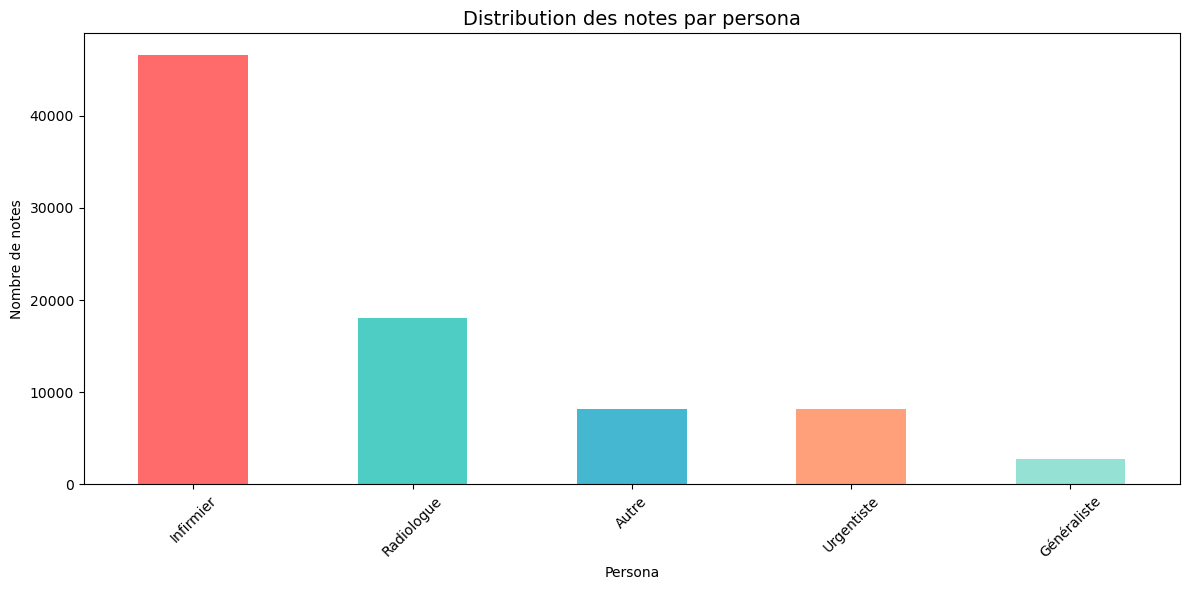


 Colonne persona_target créée


In [16]:
# --------------------------------------------
# 1.11 CRÉER COLONNE PERSONA_TARGET
# --------------------------------------------

print("\n Création colonne persona_target...")

# Mapping catégories → personas
persona_mapping = {
    'Urgentiste': ['Physician', 'ECG', 'Echo'],
    'Généraliste': ['Discharge summary'],
    'Radiologue': ['Radiology'],
    'Infirmier': ['Nursing', 'Nursing/other'],
    'Respiratoire': ['Respiratory'],
    'Autre': []
}

def assign_persona(category):
    """Assigne un persona basé sur la catégorie de note"""
    for persona, categories in persona_mapping.items():
        if category in categories:
            return persona
    return 'Autre'

# Appliquer
notes_filtered['persona_target'] = notes_filtered['CATEGORY'].apply(assign_persona)

# Distribution
print(f"\n Distribution par persona :")
persona_dist = notes_filtered['persona_target'].value_counts()
print(persona_dist)

# Visualisation
plt.figure(figsize=(12, 6))
persona_dist.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3', '#A8E6CF'])
plt.title('Distribution des notes par persona', fontsize=14)
plt.xlabel('Persona')
plt.ylabel('Nombre de notes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n Colonne persona_target créée")

In [17]:
# --------------------------------------------
# 1.12 FEATURES ADDITIONNELLES
# --------------------------------------------

print("\n Création features additionnelles...")

# Présence de sections standard
print("  - Détection sections médicales...")
notes_filtered['has_history'] = notes_filtered['TEXT_CLEAN'].str.contains(
    'history', case=False, na=False
).astype(int)

notes_filtered['has_medications'] = notes_filtered['TEXT_CLEAN'].str.contains(
    'medication', case=False, na=False
).astype(int)

notes_filtered['has_exam'] = notes_filtered['TEXT_CLEAN'].str.contains(
    'exam|physical', case=False, na=False
).astype(int)

notes_filtered['has_plan'] = notes_filtered['TEXT_CLEAN'].str.contains(
    'plan|discharge', case=False, na=False
).astype(int)

# Score d'urgence (mots-clés d'urgence)
urgent_keywords = ['emergency', 'urgent', 'acute', 'stat', 'critical', 'severe']
notes_filtered['urgency_score'] = notes_filtered['TEXT_CLEAN'].apply(
    lambda x: sum([1 for kw in urgent_keywords if kw in str(x).lower()])
)

print(f" Features additionnelles créées")
print(f"\nRésumé features :")
print(f"  - has_history : {notes_filtered['has_history'].sum():,} notes ({notes_filtered['has_history'].mean()*100:.1f}%)")
print(f"  - has_medications : {notes_filtered['has_medications'].sum():,} notes ({notes_filtered['has_medications'].mean()*100:.1f}%)")
print(f"  - has_exam : {notes_filtered['has_exam'].sum():,} notes ({notes_filtered['has_exam'].mean()*100:.1f}%)")
print(f"  - has_plan : {notes_filtered['has_plan'].sum():,} notes ({notes_filtered['has_plan'].mean()*100:.1f}%)")
print(f"  - urgency_score moyen : {notes_filtered['urgency_score'].mean():.2f}")


 Création features additionnelles...
  - Détection sections médicales...
 Features additionnelles créées

Résumé features :
  - has_history : 16,778 notes (20.0%)
  - has_medications : 10,096 notes (12.1%)
  - has_exam : 32,221 notes (38.5%)
  - has_plan : 37,680 notes (45.0%)
  - urgency_score moyen : 0.63


In [18]:
# --------------------------------------------
# 1.13 VÉRIFICATIONS FINALES
# --------------------------------------------

print("\n VÉRIFICATIONS FINALES...")

# 1. Vérifier valeurs manquantes critiques
print("\n Valeurs manquantes dans colonnes critiques :")
critical_cols = ['SUBJECT_ID', 'HADM_ID', 'TEXT', 'TEXT_CLEAN', 'CATEGORY', 'persona_target']
for col in critical_cols:
    missing = notes_filtered[col].isna().sum()
    print(f"  - {col}: {missing:,} ({missing/len(notes_filtered)*100:.2f}%)")

# 2. Vérifier doublons
duplicates = notes_filtered.duplicated(subset=['ROW_ID']).sum()
print(f"\n🔍 Doublons (ROW_ID) : {duplicates:,}")

# 3. Vérifier cohérence IDs
print(f"\n Cohérence IDs :")
print(f"  - Patients uniques : {notes_filtered['SUBJECT_ID'].nunique():,}")
print(f"  - Hospitalisations uniques : {notes_filtered['HADM_ID'].nunique():,}")
print(f"  - Notes par patient (moyenne) : {len(notes_filtered)/notes_filtered['SUBJECT_ID'].nunique():.1f}")

# 4. Distribution longueurs par persona
print(f"\n Longueur moyenne par persona :")
length_by_persona = notes_filtered.groupby('persona_target')['text_length'].agg(['count', 'mean', 'median']).round(0)
print(length_by_persona)


 VÉRIFICATIONS FINALES...

 Valeurs manquantes dans colonnes critiques :
  - SUBJECT_ID: 0 (0.00%)
  - HADM_ID: 0 (0.00%)
  - TEXT: 0 (0.00%)
  - TEXT_CLEAN: 0 (0.00%)
  - CATEGORY: 0 (0.00%)
  - persona_target: 0 (0.00%)

🔍 Doublons (ROW_ID) : 0

 Cohérence IDs :
  - Patients uniques : 2,144
  - Hospitalisations uniques : 2,778
  - Notes par patient (moyenne) : 39.0

 Longueur moyenne par persona :
                count    mean  median
persona_target                       
Autre            8140  4013.0  4086.0
Généraliste      2734  8306.0  7890.0
Infirmier       46601   934.0   747.0
Radiologue      18091  1411.0  1096.0
Urgentiste       8132   595.0   213.0


In [21]:
# --------------------------------------------
# 1.14 SAUVEGARDER
# --------------------------------------------

print("\n💾 Sauvegarde des données nettoyées...")

# Sauvegarder
output_path = "/Users/ines/m-dic-AIde/data/staging/notes_clean.csv"
notes_filtered.to_csv(output_path, index=False)

print(f"✅ Fichier sauvegardé : {output_path}")





💾 Sauvegarde des données nettoyées...
✅ Fichier sauvegardé : /Users/ines/m-dic-AIde/data/staging/notes_clean.csv


In [28]:
from pathlib import Path

# Si ton chemin est une string
output_path = "/Users/ines/m-dic-AIde/data/staging/notes_clean.csv"

# Convertir en Path pour utiliser .stat()
output_path = Path(output_path)

# Maintenant tu peux obtenir la taille
file_size_mb = output_path.stat().st_size / 1024 / 1024
print(f"Taille du fichier : {file_size_mb:.1f} MB")

Taille du fichier : 279.3 MB


In [29]:
# Affichage du rapport final après nettoyage de NOTEEVENTS

# Séparateur visuel
print("\n" + "=" * 60)
print(" RAPPORT FINAL - NETTOYAGE NOTEEVENTS")
print("=" * 60)

# Construction du rapport
report = f"""
AVANT NETTOYAGE :
  • Notes totales : {len(notes):,}
  • Patients : {notes['SUBJECT_ID'].nunique():,}
  • Hospitalisations : {notes['HADM_ID'].nunique():,}

APRÈS NETTOYAGE :
  • Notes nettoyées : {len(notes_filtered):,} ({len(notes_filtered)/len(notes)*100:.1f}% conservé)
  • Patients : {notes_filtered['SUBJECT_ID'].nunique():,}
  • Hospitalisations : {notes_filtered['HADM_ID'].nunique():,}

🔧 OPÉRATIONS EFFECTUÉES :
  1. Filtrage patients/hospitalisations communs
  2. Suppression notes sans HADM_ID
  3. Suppression colonnes inutiles (ISERROR, STORETIME, CGID)
  4. Nettoyage textes (dates anonymisées, espaces)
  5. Suppression notes < 50 caractères ({len(very_short):,} notes)
  6. Suppression notes > 20k caractères ({len(very_long):,} notes)
  7. Conversion dates en datetime
  8. Création colonne persona_target
  9. Création features additionnelles (urgency_score, sections, etc.)

DISTRIBUTION PAR PERSONA :
{persona_dist.to_string()}

QUALITÉ TEXTUELLE :
  • Longueur moyenne : {notes_filtered['text_length'].mean():.0f} caractères
  • Longueur médiane : {notes_filtered['text_length'].median():.0f} caractères
  • Notes avec section History : {notes_filtered['has_history'].sum():,} ({notes_filtered['has_history'].mean()*100:.1f}%)
  • Notes avec section Medications : {notes_filtered['has_medications'].sum():,} ({notes_filtered['has_medications'].mean()*100:.1f}%)

FICHIER SAUVEGARDÉ :
  • {output_path}
  • Taille : {output_path.stat().st_size / 1024 / 1024:.1f} MB
  • Colonnes : {notes_filtered.shape[1]}
"""

# Affichage complet du rapport
print(report)


 RAPPORT FINAL - NETTOYAGE NOTEEVENTS

AVANT NETTOYAGE :
  • Notes totales : 458,090
  • Patients : 10,000
  • Hospitalisations : 12,722

APRÈS NETTOYAGE :
  • Notes nettoyées : 83,698 (18.3% conservé)
  • Patients : 2,144
  • Hospitalisations : 2,778

🔧 OPÉRATIONS EFFECTUÉES :
  1. Filtrage patients/hospitalisations communs
  2. Suppression notes sans HADM_ID
  3. Suppression colonnes inutiles (ISERROR, STORETIME, CGID)
  4. Nettoyage textes (dates anonymisées, espaces)
  5. Suppression notes < 50 caractères (366 notes)
  6. Suppression notes > 20k caractères (76 notes)
  7. Conversion dates en datetime
  8. Création colonne persona_target
  9. Création features additionnelles (urgency_score, sections, etc.)

DISTRIBUTION PAR PERSONA :
persona_target
Infirmier      46601
Radiologue     18091
Autre           8140
Urgentiste      8132
Généraliste     2734

QUALITÉ TEXTUELLE :
  • Longueur moyenne : 1544 caractères
  • Longueur médiane : 949 caractères
  • Notes avec section History : 1

In [30]:
# ============================================
# SECTION 2 : NETTOYAGE DIAGNOSES_ICD
# ============================================
print("\n" + "=" * 60)
print(" NETTOYAGE DIAGNOSES_ICD")
print("=" * 60)

# --------------------------------------------
# 2.1 CHARGEMENT
# --------------------------------------------
print("\nChargement des fichiers...")
# Charger DIAGNOSES_ICD (déjà chargé avant, mais on recharge pour être sûr)
diagnoses = pd.read_csv("/Users/ines/m-dic-AIde/data/raw/DIAGNOSES_ICD_random.csv")
print(f" DIAGNOSES_ICD chargé : {len(diagnoses):,} lignes")

# Charger dictionnaire ICD
d_icd_diag = pd.read_csv("/Users/ines/m-dic-AIde/data/raw/D_ICD_DIAGNOSES.csv")
print(f" D_ICD_DIAGNOSES chargé : {len(d_icd_diag):,} codes")


 NETTOYAGE DIAGNOSES_ICD

Chargement des fichiers...
 DIAGNOSES_ICD chargé : 140,502 lignes
 D_ICD_DIAGNOSES chargé : 14,567 codes


In [31]:

print(f"\n AVANT NETTOYAGE :")
print(f"  - Diagnostics : {len(diagnoses):,}")
print(f"  - Colonnes : {diagnoses.shape[1]}")
print(f"  - Patients : {diagnoses['SUBJECT_ID'].nunique():,}")
print(f"  - Hospitalisations : {diagnoses['HADM_ID'].nunique():,}")


 AVANT NETTOYAGE :
  - Diagnostics : 140,502
  - Colonnes : 5
  - Patients : 10,000
  - Hospitalisations : 12,745


In [32]:
# --------------------------------------------
# 2.2 FILTRAGE : PATIENTS ET HOSPITALISATIONS COMMUNS
# --------------------------------------------

print("\n FILTRAGE : Patients et hospitalisations communs...")

diagnoses_filtered = diagnoses[
    (diagnoses['SUBJECT_ID'].isin(patients_communs)) & 
    (diagnoses['HADM_ID'].isin(hadm_communs))
].copy()

print(f" Diagnostics après filtrage communs : {len(diagnoses_filtered):,} ({len(diagnoses_filtered)/len(diagnoses)*100:.1f}%)")


 FILTRAGE : Patients et hospitalisations communs...
 Diagnostics après filtrage communs : 30,802 (21.9%)


In [33]:
# --------------------------------------------
# 2.3 VÉRIFIER VALEURS MANQUANTES
# --------------------------------------------

print("\n Vérification valeurs manquantes...")

missing = diagnoses_filtered.isnull().sum()
missing_pct = (missing / len(diagnoses_filtered)) * 100

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})

print(missing_df[missing_df['Missing'] > 0])

# Supprimer lignes avec SEQ_NUM ou ICD9_CODE manquants
if missing['SEQ_NUM'] > 0 or missing['ICD9_CODE'] > 0:
    print(f"\n Suppression lignes avec SEQ_NUM ou ICD9_CODE manquants...")
    diagnoses_filtered = diagnoses_filtered.dropna(subset=['SEQ_NUM', 'ICD9_CODE'])
    print(f" Diagnostics après suppression manquants : {len(diagnoses_filtered):,}")


 Vérification valeurs manquantes...
           Missing  Percentage
SEQ_NUM          2    0.006493
ICD9_CODE        2    0.006493

 Suppression lignes avec SEQ_NUM ou ICD9_CODE manquants...
 Diagnostics après suppression manquants : 30,800


In [34]:
# --------------------------------------------
# 2.4 ENRICHIR AVEC DESCRIPTIONS (D_ICD_DIAGNOSES)
# --------------------------------------------

print("\n Enrichissement avec descriptions ICD...")

# Merger avec dictionnaire ICD
diagnoses_enriched = diagnoses_filtered.merge(
    d_icd_diag[['ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']],
    on='ICD9_CODE',
    how='left'
)

print(f" Diagnostics enrichis : {len(diagnoses_enriched):,} lignes")

# Vérifier codes sans description
codes_sans_desc = diagnoses_enriched['SHORT_TITLE'].isna().sum()
print(f"\n Codes sans description : {codes_sans_desc:,} ({codes_sans_desc/len(diagnoses_enriched)*100:.1f}%)")

if codes_sans_desc > 0:
    print(f"\nExemples de codes sans description :")
    missing_codes = diagnoses_enriched[diagnoses_enriched['SHORT_TITLE'].isna()]['ICD9_CODE'].value_counts().head(10)
    print(missing_codes)


 Enrichissement avec descriptions ICD...
 Diagnostics enrichis : 30,800 lignes

 Codes sans description : 782 (2.5%)

Exemples de codes sans description :
ICD9_CODE
5185    79
2765    73
7793    55
9974    48
0414    48
2554    34
2841    29
4538    28
V721    24
5997    22
Name: count, dtype: int64


In [35]:
# --------------------------------------------
# 2.5 GÉRER CODES SANS DESCRIPTION
# --------------------------------------------

print("\n Gestion des codes sans description...")

# Option 1 : Supprimer (RECOMMANDÉ si < 5%)
if codes_sans_desc / len(diagnoses_enriched) < 0.05:
    print(f"  → Suppression des {codes_sans_desc:,} codes sans description (< 5%)")
    diagnoses_clean = diagnoses_enriched.dropna(subset=['SHORT_TITLE'])
    print(f" Diagnostics après suppression : {len(diagnoses_clean):,}")
else:
    # Option 2 : Label générique
    print(f"  → Remplacement par 'Unknown diagnosis' ({codes_sans_desc:,} codes)")
    diagnoses_clean = diagnoses_enriched.copy()
    diagnoses_clean['SHORT_TITLE'].fillna('Unknown diagnosis', inplace=True)
    diagnoses_clean['LONG_TITLE'].fillna('Unknown diagnosis', inplace=True)
    print(f" Diagnostics après remplacement : {len(diagnoses_clean):,}")


 Gestion des codes sans description...
  → Suppression des 782 codes sans description (< 5%)
 Diagnostics après suppression : 30,018


In [36]:
# --------------------------------------------
# 2.6 VÉRIFIER COHÉRENCE SEQ_NUM
# --------------------------------------------

print("\n Vérification cohérence SEQ_NUM...")

# Statistiques SEQ_NUM
print(f"\n Distribution SEQ_NUM :")
print(diagnoses_clean['SEQ_NUM'].describe())

# Compter diagnostics principaux (SEQ_NUM = 1)
principal_count = (diagnoses_clean['SEQ_NUM'] == 1).sum()
print(f"\n Diagnostics principaux (SEQ_NUM=1) : {principal_count:,}")

# Vérifier hospitalisations sans diagnostic principal
diag_principal = diagnoses_clean[diagnoses_clean['SEQ_NUM'] == 1]
hadm_with_principal = set(diag_principal['HADM_ID'].unique())
hadm_without_principal = hadm_communs - hadm_with_principal

if len(hadm_without_principal) > 0:
    print(f" Hospitalisations SANS diagnostic principal : {len(hadm_without_principal):,}")
else:
    print(f" Toutes les hospitalisations ont un diagnostic principal")

# Distribution SEQ_NUM
seq_dist = diagnoses_clean['SEQ_NUM'].value_counts().sort_index().head(15)
print(f"\n Distribution SEQ_NUM (top 15) :")
print(seq_dist)


 Vérification cohérence SEQ_NUM...

 Distribution SEQ_NUM :
count    30018.000000
mean         7.933473
std          6.019187
min          1.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         39.000000
Name: SEQ_NUM, dtype: float64

 Diagnostics principaux (SEQ_NUM=1) : 2,744
 Hospitalisations SANS diagnostic principal : 34

 Distribution SEQ_NUM (top 15) :
SEQ_NUM
1.0     2744
2.0     2666
3.0     2604
4.0     2477
5.0     2348
6.0     2168
7.0     2021
8.0     1855
9.0     1703
10.0    1295
11.0    1175
12.0    1038
13.0     913
14.0     801
15.0     694
Name: count, dtype: int64



 STATISTIQUES DIAGNOSTICS...

 Top 20 codes ICD-9 les plus fréquents :
ICD9_CODE
4019     903
4280     628
42731    611
41401    601
5849     450
25000    416
2724     384
51881    341
5990     298
53081    283
V053     263
2720     262
2859     261
V290     257
2762     229
486      226
496      219
2449     216
2851     215
0389     198
Name: count, dtype: int64

 Top 20 diagnostics (avec descriptions) :
SHORT_TITLE
Hypertension NOS            903
CHF NOS                     628
Atrial fibrillation         611
Crnry athrscl natve vssl    601
Acute kidney failure NOS    450
DMII wo cmp nt st uncntr    416
Hyperlipidemia NEC/NOS      384
Acute respiratry failure    341
Urin tract infection NOS    298
Esophageal reflux           283
Need prphyl vc vrl hepat    263
Pure hypercholesterolem     262
Anemia NOS                  261
NB obsrv suspct infect      257
Acidosis                    229
Pneumonia, organism NOS     226
Chr airway obstruct NEC     219
Hypothyroidism NOS          216
A

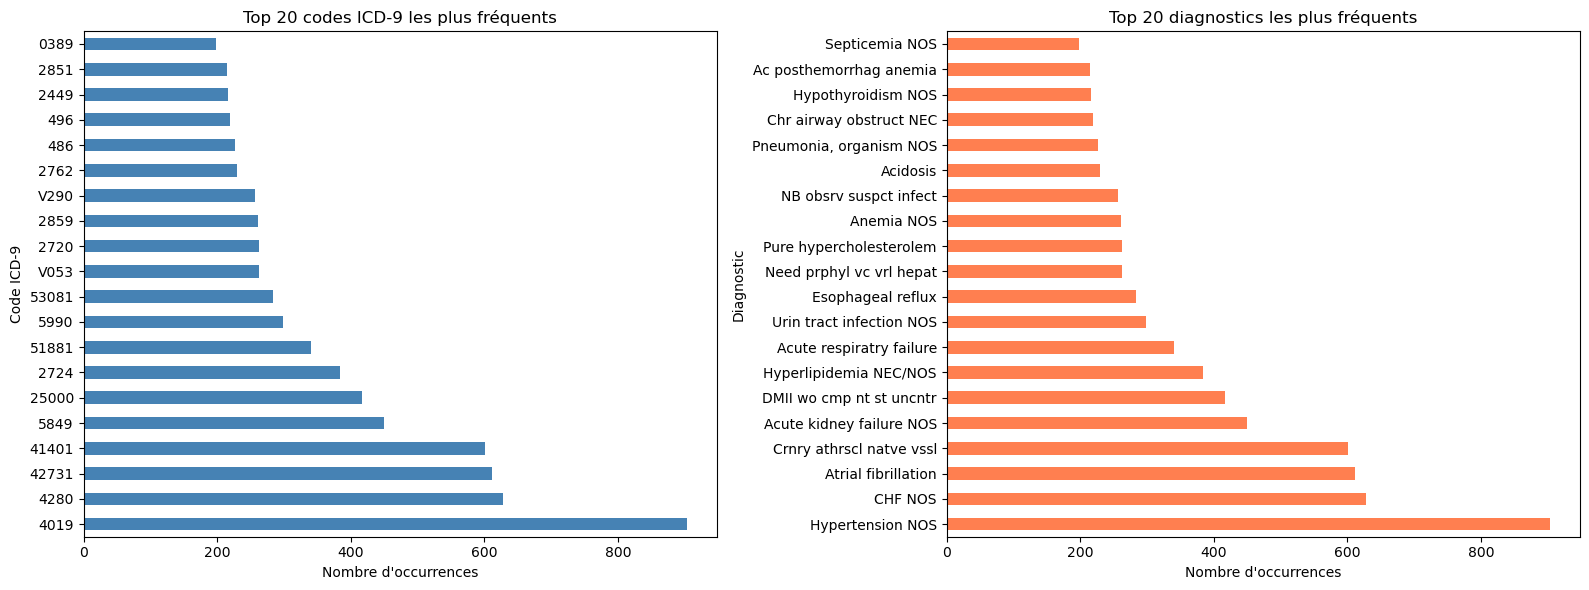

In [37]:
# --------------------------------------------
# 2.7 STATISTIQUES DIAGNOSTICS
# --------------------------------------------

print("\n STATISTIQUES DIAGNOSTICS...")

# Top 20 codes ICD
print(f"\n Top 20 codes ICD-9 les plus fréquents :")
top_codes = diagnoses_clean['ICD9_CODE'].value_counts().head(20)
print(top_codes)

# Top 20 diagnostics avec descriptions
print(f"\n Top 20 diagnostics (avec descriptions) :")
top_diagnoses = diagnoses_clean['SHORT_TITLE'].value_counts().head(20)
print(top_diagnoses)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top codes
top_codes.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 20 codes ICD-9 les plus fréquents', fontsize=12)
axes[0].set_xlabel('Nombre d\'occurrences')
axes[0].set_ylabel('Code ICD-9')

# Top diagnostics
top_diagnoses.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 20 diagnostics les plus fréquents', fontsize=12)
axes[1].set_xlabel('Nombre d\'occurrences')
axes[1].set_ylabel('Diagnostic')

plt.tight_layout()
plt.show()


 DIAGNOSTICS PAR HOSPITALISATION...

 Statistiques diagnostics par hospitalisation :
count    2776.000000
mean       10.813401
std         6.343823
min         1.000000
25%         6.000000
50%         9.000000
75%        14.000000
max        39.000000
dtype: float64


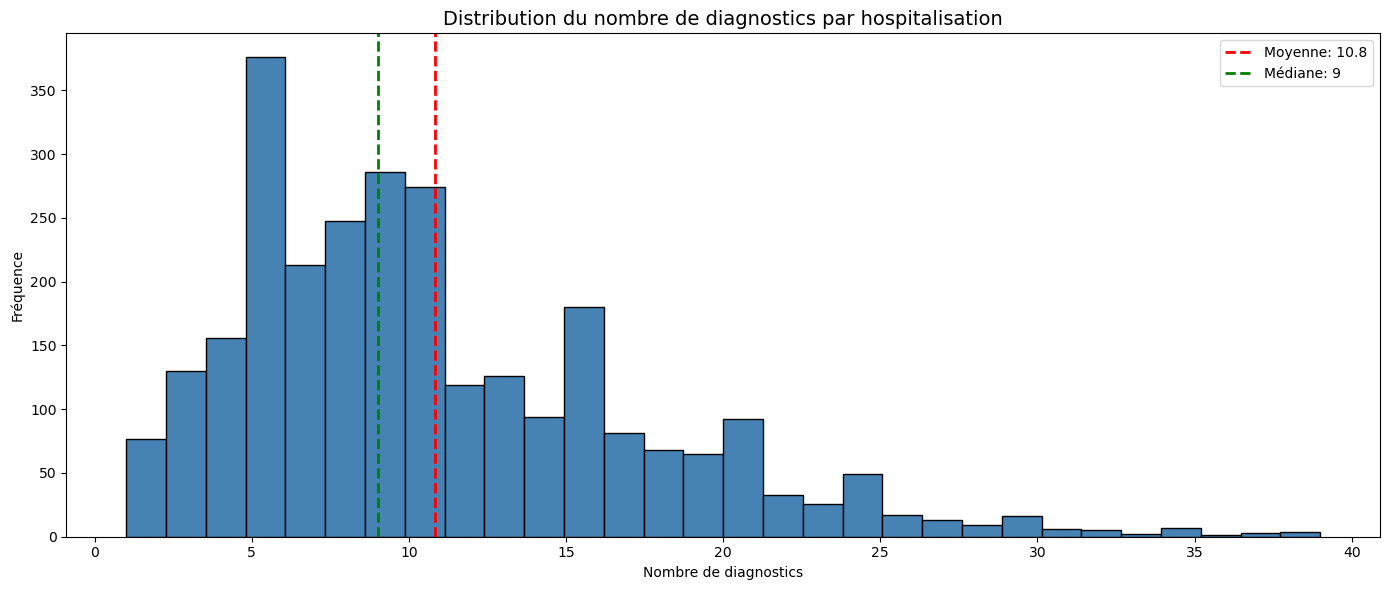

In [39]:
# --------------------------------------------
# 2.8 DIAGNOSTICS PAR HOSPITALISATION
# --------------------------------------------

print("\n DIAGNOSTICS PAR HOSPITALISATION...")

# Nombre de diagnostics par hospitalisation
diag_per_hadm = diagnoses_clean.groupby('HADM_ID').size()

print(f"\n Statistiques diagnostics par hospitalisation :")
print(diag_per_hadm.describe())

# Visualisation
plt.figure(figsize=(14, 6))
diag_per_hadm.plot(kind='hist', bins=30, edgecolor='black', color='steelblue')
plt.title('Distribution du nombre de diagnostics par hospitalisation', fontsize=14)
plt.xlabel('Nombre de diagnostics')
plt.ylabel('Fréquence')
plt.axvline(diag_per_hadm.mean(), color='red', linestyle='--', 
            label=f'Moyenne: {diag_per_hadm.mean():.1f}', linewidth=2)
plt.axvline(diag_per_hadm.median(), color='green', linestyle='--', 
            label=f'Médiane: {diag_per_hadm.median():.0f}', linewidth=2)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# --------------------------------------------
# 2.9 VÉRIFICATIONS FINALES
# --------------------------------------------

print("\n VÉRIFICATIONS FINALES...")

# Valeurs manquantes
print(f"\n Valeurs manquantes dans colonnes critiques :")
critical_cols = ['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'SHORT_TITLE']
for col in critical_cols:
    missing = diagnoses_clean[col].isna().sum()
    print(f"  - {col}: {missing:,} ({missing/len(diagnoses_clean)*100:.2f}%)")

# Doublons
duplicates = diagnoses_clean.duplicated(subset=['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM']).sum()
print(f"\n Doublons potentiels (SUBJECT_ID, HADM_ID, SEQ_NUM) : {duplicates:,}")

# Cohérence
print(f"\n Cohérence :")
print(f"  - Patients uniques : {diagnoses_clean['SUBJECT_ID'].nunique():,}")
print(f"  - Hospitalisations uniques : {diagnoses_clean['HADM_ID'].nunique():,}")
print(f"  - Codes ICD uniques : {diagnoses_clean['ICD9_CODE'].nunique():,}")
print(f"  - Diagnostics par patient (moyenne) : {len(diagnoses_clean)/diagnoses_clean['SUBJECT_ID'].nunique():.1f}")


 VÉRIFICATIONS FINALES...

 Valeurs manquantes dans colonnes critiques :
  - SUBJECT_ID: 0 (0.00%)
  - HADM_ID: 0 (0.00%)
  - SEQ_NUM: 0 (0.00%)
  - ICD9_CODE: 0 (0.00%)
  - SHORT_TITLE: 0 (0.00%)

 Doublons potentiels (SUBJECT_ID, HADM_ID, SEQ_NUM) : 0

 Cohérence :
  - Patients uniques : 2,144
  - Hospitalisations uniques : 2,776
  - Codes ICD uniques : 2,763
  - Diagnostics par patient (moyenne) : 14.0


In [44]:
diagnoses_with_principal = diagnoses_clean[
    diagnoses_clean['HADM_ID'].isin(
        diagnoses_clean[diagnoses_clean['SEQ_NUM'] == 1]['HADM_ID']
    )
]

In [45]:
# --------------------------------------------
# 2.10 SAUVEGARDER
# --------------------------------------------

from pathlib import Path

print("\n Sauvegarde des diagnostics nettoyés...")

# Chemin propre (sans apostrophe en trop)
output_path = Path("/Users/ines/m-dic-AIde/data/staging/diagnoses_clean.csv")

# Sauvegarde
diagnoses_clean.to_csv(output_path, index=False)

# Taille du fichier
file_size_mb = output_path.stat().st_size / 1024 / 1024

print(f" Fichier sauvegardé : {output_path}")
print(f"   Taille : {file_size_mb:.1f} MB")
print(f"   Lignes : {len(diagnoses_clean):,}")
print(f"   Colonnes : {diagnoses_clean.shape[1]}")


 Sauvegarde des diagnostics nettoyés...
 Fichier sauvegardé : /Users/ines/m-dic-AIde/data/staging/diagnoses_clean.csv
   Taille : 2.7 MB
   Lignes : 30,018
   Colonnes : 7


In [43]:
# --------------------------------------------
# 2.11 RAPPORT FINAL
# --------------------------------------------

print("\n" + "=" * 60)
print(" RAPPORT FINAL - NETTOYAGE DIAGNOSES_ICD")
print("=" * 60)

report = f"""
🧹 NETTOYAGE DIAGNOSES_ICD - RÉSUMÉ

 AVANT NETTOYAGE :
  • Diagnostics totaux : {len(diagnoses):,}
  • Patients : {diagnoses['SUBJECT_ID'].nunique():,}
  • Hospitalisations : {diagnoses['HADM_ID'].nunique():,}

 APRÈS NETTOYAGE :
  • Diagnostics nettoyés : {len(diagnoses_clean):,} ({len(diagnoses_clean)/len(diagnoses)*100:.1f}% conservé)
  • Patients : {diagnoses_clean['SUBJECT_ID'].nunique():,}
  • Hospitalisations : {diagnoses_clean['HADM_ID'].nunique():,}
  • Codes ICD uniques : {diagnoses_clean['ICD9_CODE'].nunique():,}

🔧 OPÉRATIONS EFFECTUÉES :
  1.  Filtrage patients/hospitalisations communs
  2.  Suppression diagnostics avec SEQ_NUM/ICD9_CODE manquants
  3.  Enrichissement avec descriptions (D_ICD_DIAGNOSES)
  4.  Gestion codes sans description ({codes_sans_desc:,} codes)
  5.  Vérification cohérence SEQ_NUM
  6.  Validation diagnostics principaux

 STATISTIQUES :
  • Diagnostics par hospitalisation :
    - Moyenne : {diag_per_hadm.mean():.1f}
    - Médiane : {diag_per_hadm.median():.0f}
    - Min : {diag_per_hadm.min():.0f}
    - Max : {diag_per_hadm.max():.0f}
  
  • Diagnostics principaux (SEQ_NUM=1) : {principal_count:,}
  • Top diagnostic : {top_diagnoses.index[0]} ({top_diagnoses.iloc[0]:,} occurrences)

 TOP 5 DIAGNOSTICS :
{top_diagnoses.head(5).to_string()}

 FICHIER SAUVEGARDÉ :
  • {output_path}
  • Taille : {output_path.stat().st_size / 1024 / 1024:.1f} MB
  • Colonnes : {diagnoses_clean.shape[1]}

 PRÊT POUR ÉTAPE SUIVANTE : Agrégation diagnostics par hospitalisation
"""

print(report)

# Sauvegarder le rapport
with open("/Users/ines/m-dic-AIde/data/staging/cleaning_report_diagnoses.txt", 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✅ Rapport sauvegardé : data/staging/cleaning_report_diagnoses.txt")
print("\n🎉 NETTOYAGE DIAGNOSES_ICD TERMINÉ !")
""


 RAPPORT FINAL - NETTOYAGE DIAGNOSES_ICD

🧹 NETTOYAGE DIAGNOSES_ICD - RÉSUMÉ

 AVANT NETTOYAGE :
  • Diagnostics totaux : 140,502
  • Patients : 10,000
  • Hospitalisations : 12,745

 APRÈS NETTOYAGE :
  • Diagnostics nettoyés : 30,018 (21.4% conservé)
  • Patients : 2,144
  • Hospitalisations : 2,776
  • Codes ICD uniques : 2,763

🔧 OPÉRATIONS EFFECTUÉES :
  1.  Filtrage patients/hospitalisations communs
  2.  Suppression diagnostics avec SEQ_NUM/ICD9_CODE manquants
  3.  Enrichissement avec descriptions (D_ICD_DIAGNOSES)
  4.  Gestion codes sans description (782 codes)
  5.  Vérification cohérence SEQ_NUM
  6.  Validation diagnostics principaux

 STATISTIQUES :
  • Diagnostics par hospitalisation :
    - Moyenne : 10.8
    - Médiane : 9
    - Min : 1
    - Max : 39
  
  • Diagnostics principaux (SEQ_NUM=1) : 2,744
  • Top diagnostic : Hypertension NOS (903 occurrences)

 TOP 5 DIAGNOSTICS :
SHORT_TITLE
Hypertension NOS            903
CHF NOS                     628
Atrial fibrillati

''

In [46]:
# ============================================
# SECTION 3 : AGRÉGATION DES DIAGNOSTICS
# ============================================
print("\n" + "=" * 60)
print(" AGRÉGATION DES DIAGNOSTICS PAR HOSPITALISATION")
print("=" * 60)


 AGRÉGATION DES DIAGNOSTICS PAR HOSPITALISATION


In [48]:
# --------------------------------------------
# 3.1 CHARGEMENT
# --------------------------------------------

print("\n Chargement des données nettoyées...")

# Charger diagnostics nettoyés
diagnoses_clean = pd.read_csv("/Users/ines/m-dic-AIde/data/staging/diagnoses_clean.csv")
print(f" Diagnostics chargés : {len(diagnoses_clean):,} lignes")

print(f"\n AVANT AGRÉGATION :")
print(f"  - Diagnostics : {len(diagnoses_clean):,}")
print(f"  - Hospitalisations : {diagnoses_clean['HADM_ID'].nunique():,}")
print(f"  - Diagnostics par hospitalisation (moyenne) : {len(diagnoses_clean)/diagnoses_clean['HADM_ID'].nunique():.1f}")


 Chargement des données nettoyées...
 Diagnostics chargés : 30,018 lignes

 AVANT AGRÉGATION :
  - Diagnostics : 30,018
  - Hospitalisations : 2,776
  - Diagnostics par hospitalisation (moyenne) : 10.8


In [49]:
# --------------------------------------------
# 3.2 IDENTIFIER DIAGNOSTIC PRINCIPAL
# --------------------------------------------

print("\n Identification des diagnostics principaux...")

# Extraire diagnostics principaux (SEQ_NUM = 1)
diag_principal = diagnoses_clean[diagnoses_clean['SEQ_NUM'] == 1].copy()

print(f" Diagnostics principaux identifiés : {len(diag_principal):,}")

# Vérifier hospitalisations sans diagnostic principal
hadm_with_principal = set(diag_principal['HADM_ID'].unique())
hadm_all = set(diagnoses_clean['HADM_ID'].unique())
hadm_without_principal = hadm_all - hadm_with_principal

if len(hadm_without_principal) > 0:
    print(f" Hospitalisations SANS diagnostic principal : {len(hadm_without_principal):,}")
    print(f"   Ces hospitalisations seront marquées avec diagnosis_principal='Unknown'")
else:
    print(f" Toutes les hospitalisations ont un diagnostic principal")

# Créer mapping HADM_ID → Diagnostic principal
principal_mapping = diag_principal.set_index('HADM_ID')['SHORT_TITLE'].to_dict()


 Identification des diagnostics principaux...
 Diagnostics principaux identifiés : 2,744
 Hospitalisations SANS diagnostic principal : 32
   Ces hospitalisations seront marquées avec diagnosis_principal='Unknown'


In [50]:
# --------------------------------------------
# 3.3 AGRÉGATION - MÉTHODE 1 : LISTES
# --------------------------------------------

print("\n Agrégation des diagnostics (méthode 1 : listes)...")

# Agréger par hospitalisation
diagnoses_aggregated = diagnoses_clean.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'ICD9_CODE': list,           # Liste de tous les codes
    'SHORT_TITLE': list,          # Liste de toutes les descriptions
    'SEQ_NUM': 'count'            # Nombre total de diagnostics
}).reset_index()

# Renommer colonnes
diagnoses_aggregated.columns = ['SUBJECT_ID', 'HADM_ID', 'diagnosis_codes_list', 
                                 'diagnosis_labels_list', 'num_diagnoses']

print(f" Diagnostics agrégés : {len(diagnoses_aggregated):,} hospitalisations")
print(f"\nAperçu :")
print(diagnoses_aggregated.head())


 Agrégation des diagnostics (méthode 1 : listes)...
 Diagnostics agrégés : 2,776 hospitalisations

Aperçu :
   SUBJECT_ID  HADM_ID                               diagnosis_codes_list  \
0          42   119203      [42741, 4280, 41400, 412, 4019, 43820, 43819]   
1          49   190539  [4241, 42731, 4280, 496, 2939, 40390, 56409, 3...   
2          57   162774                    [V3001, 7661, V053, V290, V293]   
3         112   173177  [0389, 78552, 486, 20300, 27651, 5849, 40391, ...   
4         112   174105                   [53100, 41071, 2859, 41401, 725]   

                               diagnosis_labels_list  num_diagnoses  
0  [Ventricular fibrillation, CHF NOS, Cor ath un...              7  
1  [Aortic valve disorder, Atrial fibrillation, C...             11  
2  [Single lb in-hosp w cs, Heavy-for-date infan ...              5  
3  [Septicemia NOS, Septic shock, Pneumonia, orga...             13  
4  [Ac stomach ulcer w hem, Subendo infarct, init...              5  


In [51]:
# --------------------------------------------
# 3.4 AGRÉGATION - MÉTHODE 2 : STRINGS CONCATÉNÉES
# --------------------------------------------

print("\n Conversion listes → strings concaténées...")

# Fonction pour nettoyer et joindre
def join_list(lst):
    """Convertit liste en string, en retirant les NaN"""
    if isinstance(lst, list):
        # Retirer NaN et convertir en string
        clean_list = [str(x) for x in lst if pd.notna(x)]
        return ' | '.join(clean_list)
    return ""

def join_codes(lst):
    """Convertit liste de codes en string séparée par virgules"""
    if isinstance(lst, list):
        clean_list = [str(x) for x in lst if pd.notna(x)]
        return ','.join(clean_list)
    return ""

# Appliquer
diagnoses_aggregated['diagnosis_codes'] = diagnoses_aggregated['diagnosis_codes_list'].apply(join_codes)
diagnoses_aggregated['diagnosis_labels'] = diagnoses_aggregated['diagnosis_labels_list'].apply(join_list)

print(f" Conversion terminée")

# Exemple
print(f"\nExemple de diagnostics agrégés :")
example = diagnoses_aggregated.iloc[0]
print(f"\n  HADM_ID : {example['HADM_ID']}")
print(f"  Nombre de diagnostics : {example['num_diagnoses']}")
print(f"  Codes : {example['diagnosis_codes'][:100]}...")
print(f"  Labels : {example['diagnosis_labels'][:200]}...")


 Conversion listes → strings concaténées...
 Conversion terminée

Exemple de diagnostics agrégés :

  HADM_ID : 119203
  Nombre de diagnostics : 7
  Codes : 42741,4280,41400,412,4019,43820,43819...
  Labels : Ventricular fibrillation | CHF NOS | Cor ath unsp vsl ntv/gft | Old myocardial infarct | Hypertension NOS | Late ef-hemplga side NOS | Late ef-spch/lang df NEC...


In [52]:
# --------------------------------------------
# 3.5 AJOUTER DIAGNOSTIC PRINCIPAL
# --------------------------------------------

print("\n Ajout du diagnostic principal...")

# Ajouter diagnostic principal via mapping
diagnoses_aggregated['diagnosis_principal'] = diagnoses_aggregated['HADM_ID'].map(principal_mapping)

# Remplir les manquants avec "Unknown"
diagnoses_aggregated['diagnosis_principal'].fillna('Unknown', inplace=True)

# Vérifier
unknown_count = (diagnoses_aggregated['diagnosis_principal'] == 'Unknown').sum()
print(f" Diagnostic principal ajouté")
print(f"   - Avec diagnostic principal : {len(diagnoses_aggregated) - unknown_count:,}")
print(f"   - Sans diagnostic principal (Unknown) : {unknown_count:,}")


 Ajout du diagnostic principal...
 Diagnostic principal ajouté
   - Avec diagnostic principal : 2,744
   - Sans diagnostic principal (Unknown) : 32


/var/folders/rk/lx_hryp913x75xkqm9xb8fd40000gn/T/ipykernel_82502/3655055175.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnoses_aggregated['diagnosis_principal'].fillna('Unknown', inplace=True)



 Création du niveau de complexité...

 Distribution par niveau de complexité :
complexity_level
Complexe (8-12)        927
Très complexe (>12)    897
Modéré (4-7)           745
Simple (1-3)           207
Name: count, dtype: int64


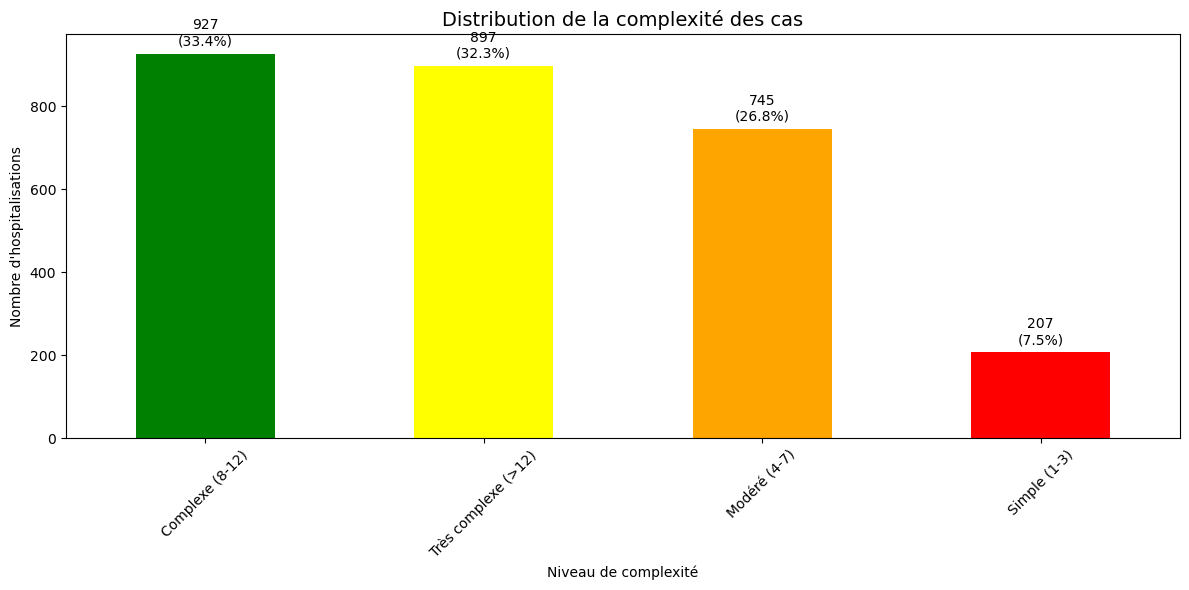

In [53]:
# --------------------------------------------
# 3.6 CRÉER NIVEAU DE COMPLEXITÉ
# --------------------------------------------

print("\n Création du niveau de complexité...")

# Classifier par nombre de diagnostics
diagnoses_aggregated['complexity_level'] = pd.cut(
    diagnoses_aggregated['num_diagnoses'],
    bins=[0, 3, 7, 12, 100],
    labels=['Simple (1-3)', 'Modéré (4-7)', 'Complexe (8-12)', 'Très complexe (>12)']
)

# Distribution
print(f"\n Distribution par niveau de complexité :")
complexity_dist = diagnoses_aggregated['complexity_level'].value_counts()
print(complexity_dist)

# Visualisation
plt.figure(figsize=(12, 6))
complexity_dist.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Distribution de la complexité des cas', fontsize=14)
plt.xlabel('Niveau de complexité')
plt.ylabel('Nombre d\'hospitalisations')
plt.xticks(rotation=45)
for i, v in enumerate(complexity_dist.values):
    plt.text(i, v + 20, f"{v:,}\n({v/len(diagnoses_aggregated)*100:.1f}%)", ha='center')
plt.tight_layout()
plt.show()

In [54]:
# --------------------------------------------
# 3.7 FEATURES ADDITIONNELLES
# --------------------------------------------

print("\n Création de features additionnelles...")

# Codes critiques (pathologies graves)
critical_codes = ['410', '518.81', '995.92', '428', '0389', '431']

def has_critical_code(codes_str):
    """Vérifie si au moins un code critique est présent"""
    if pd.isna(codes_str) or codes_str == "":
        return 0
    codes = codes_str.split(',')
    return int(any(code in critical_codes for code in codes))

diagnoses_aggregated['has_critical_condition'] = diagnoses_aggregated['diagnosis_codes'].apply(has_critical_code)

# Statistiques
critical_count = diagnoses_aggregated['has_critical_condition'].sum()
print(f" Features créées")
print(f"   - Cas avec condition critique : {critical_count:,} ({critical_count/len(diagnoses_aggregated)*100:.1f}%)")

# Catégories de pathologies principales
def categorize_diagnosis(diag_principal):
    """Catégorise le diagnostic principal"""
    if pd.isna(diag_principal) or diag_principal == 'Unknown':
        return 'Unknown'
    
    diag_lower = diag_principal.lower()
    
    # Cardiologie
    if any(word in diag_lower for word in ['heart', 'cardiac', 'coronary', 'atrial', 'infarct']):
        return 'Cardiology'
    # Pneumologie
    elif any(word in diag_lower for word in ['respiratory', 'pneumonia', 'copd', 'lung', 'pulmonary']):
        return 'Pulmonology'
    # Neurologie
    elif any(word in diag_lower for word in ['stroke', 'hemorrhage', 'seizure', 'cerebral']):
        return 'Neurology'
    # Néphrologie
    elif any(word in diag_lower for word in ['renal', 'kidney']):
        return 'Nephrology'
    # Infection
    elif any(word in diag_lower for word in ['sepsis', 'infection', 'septicemia']):
        return 'Infectious'
    # Néonatologie
    elif any(word in diag_lower for word in ['newborn', 'neonatal', 'birth']):
        return 'Neonatology'
    else:
        return 'Other'

diagnoses_aggregated['diagnosis_category'] = diagnoses_aggregated['diagnosis_principal'].apply(categorize_diagnosis)

print(f"\n Distribution par catégorie de diagnostic :")
print(diagnoses_aggregated['diagnosis_category'].value_counts())


 Création de features additionnelles...
 Features créées
   - Cas avec condition critique : 273 (9.8%)

 Distribution par catégorie de diagnostic :
diagnosis_category
Other          2159
Infectious      178
Cardiology      151
Neurology       125
Pulmonology      79
Nephrology       43
Unknown          32
Neonatology       9
Name: count, dtype: int64



 STATISTIQUES FINALES - DIAGNOSTICS AGRÉGÉS...

 Résumé :
  - Hospitalisations : 2,776
  - Patients uniques : 2,144
  - Diagnostics par hospitalisation :
    • Moyenne : 10.8
    • Médiane : 9
    • Min : 1
    • Max : 39

 Top 10 diagnostics principaux :
diagnosis_principal
Single lb in-hosp w/o cs    163
Crnry athrscl natve vssl    144
Single lb in-hosp w cs      122
Septicemia NOS              111
Subendo infarct, initial     83
Aortic valve disorder        58
Acute respiratry failure     57
Intracerebral hemorrhage     54
Twin-mate lb-in hos w cs     44
Unknown                      32
Name: count, dtype: int64


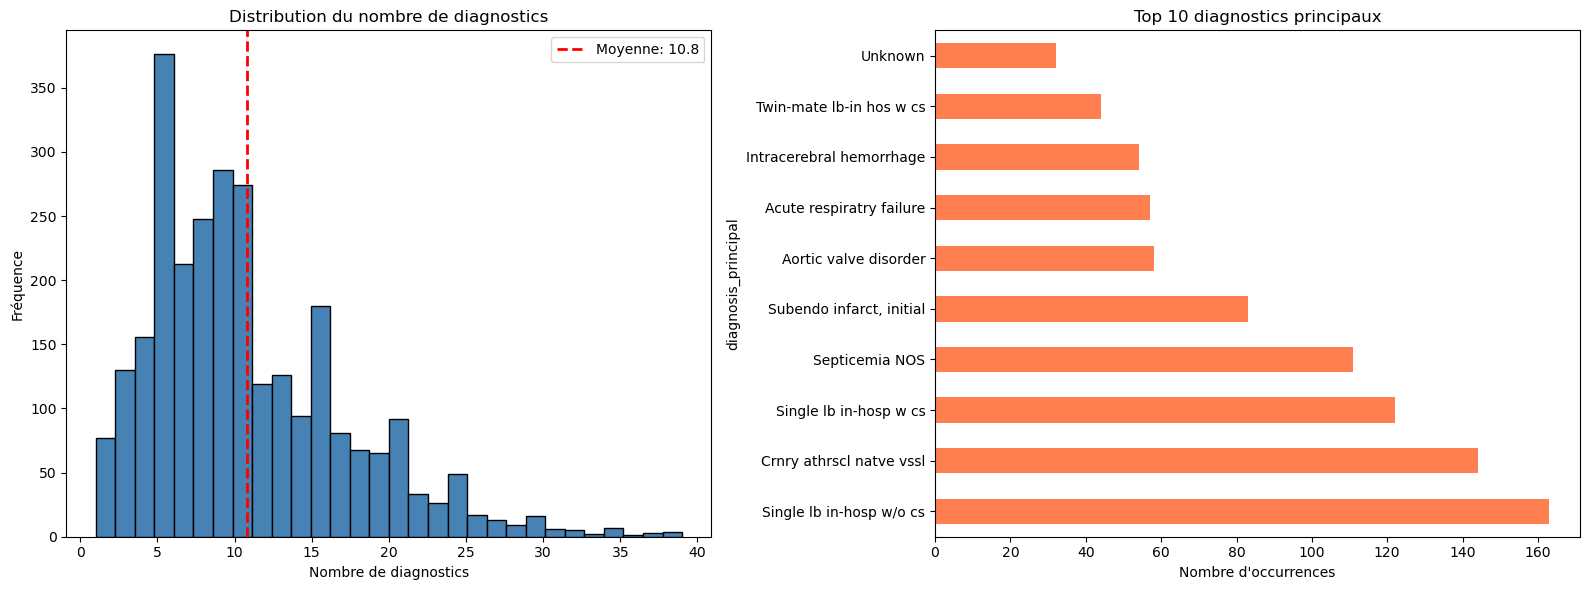

In [55]:
# --------------------------------------------
# 3.8 STATISTIQUES FINALES
# --------------------------------------------

print("\n STATISTIQUES FINALES - DIAGNOSTICS AGRÉGÉS...")

print(f"\n Résumé :")
print(f"  - Hospitalisations : {len(diagnoses_aggregated):,}")
print(f"  - Patients uniques : {diagnoses_aggregated['SUBJECT_ID'].nunique():,}")
print(f"  - Diagnostics par hospitalisation :")
print(f"    • Moyenne : {diagnoses_aggregated['num_diagnoses'].mean():.1f}")
print(f"    • Médiane : {diagnoses_aggregated['num_diagnoses'].median():.0f}")
print(f"    • Min : {diagnoses_aggregated['num_diagnoses'].min():.0f}")
print(f"    • Max : {diagnoses_aggregated['num_diagnoses'].max():.0f}")

print(f"\n Top 10 diagnostics principaux :")
top_principal = diagnoses_aggregated['diagnosis_principal'].value_counts().head(10)
print(top_principal)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution nombre diagnostics
axes[0].hist(diagnoses_aggregated['num_diagnoses'], bins=30, edgecolor='black', color='steelblue')
axes[0].set_title('Distribution du nombre de diagnostics', fontsize=12)
axes[0].set_xlabel('Nombre de diagnostics')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(diagnoses_aggregated['num_diagnoses'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Moyenne: {diagnoses_aggregated['num_diagnoses'].mean():.1f}")
axes[0].legend()

# Top diagnostics principaux
top_principal.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 10 diagnostics principaux', fontsize=12)
axes[1].set_xlabel('Nombre d\'occurrences')

plt.tight_layout()
plt.show()

In [56]:
# --------------------------------------------
# 3.9 VÉRIFICATIONS FINALES
# --------------------------------------------

print("\n VÉRIFICATIONS FINALES...")

# Valeurs manquantes
print(f"\n Valeurs manquantes :")
missing_cols = ['SUBJECT_ID', 'HADM_ID', 'diagnosis_codes', 'diagnosis_labels', 
                'diagnosis_principal', 'num_diagnoses', 'complexity_level']
for col in missing_cols:
    missing = diagnoses_aggregated[col].isna().sum()
    print(f"  - {col}: {missing:,} ({missing/len(diagnoses_aggregated)*100:.2f}%)")

# Doublons
duplicates = diagnoses_aggregated.duplicated(subset=['HADM_ID']).sum()
print(f"\n Doublons (HADM_ID) : {duplicates:,}")

# Cohérence longueurs
print(f"\n Cohérence longueurs strings :")
print(f"  - diagnosis_codes vides : {(diagnoses_aggregated['diagnosis_codes'] == '').sum():,}")
print(f"  - diagnosis_labels vides : {(diagnoses_aggregated['diagnosis_labels'] == '').sum():,}")


 VÉRIFICATIONS FINALES...

 Valeurs manquantes :
  - SUBJECT_ID: 0 (0.00%)
  - HADM_ID: 0 (0.00%)
  - diagnosis_codes: 0 (0.00%)
  - diagnosis_labels: 0 (0.00%)
  - diagnosis_principal: 0 (0.00%)
  - num_diagnoses: 0 (0.00%)
  - complexity_level: 0 (0.00%)

 Doublons (HADM_ID) : 0

 Cohérence longueurs strings :
  - diagnosis_codes vides : 0
  - diagnosis_labels vides : 0


In [57]:
# --------------------------------------------
# 3.10 NETTOYER COLONNES TEMPORAIRES
# --------------------------------------------

print("\n Nettoyage colonnes temporaires...")

# Supprimer colonnes listes (on garde les strings)
diagnoses_aggregated = diagnoses_aggregated.drop(columns=['diagnosis_codes_list', 'diagnosis_labels_list'])

print(f" Colonnes finales : {list(diagnoses_aggregated.columns)}")
print(f"   Total colonnes : {len(diagnoses_aggregated.columns)}")


 Nettoyage colonnes temporaires...
 Colonnes finales : ['SUBJECT_ID', 'HADM_ID', 'num_diagnoses', 'diagnosis_codes', 'diagnosis_labels', 'diagnosis_principal', 'complexity_level', 'has_critical_condition', 'diagnosis_category']
   Total colonnes : 9


In [59]:
from pathlib import Path

print("\n Sauvegarde des diagnostics agrégés...")

# Chemin propre
output_path = Path("/Users/ines/m-dic-AIde/data/staging/diagnoses_aggregated.csv")

# Sauvegarde
diagnoses_aggregated.to_csv(output_path, index=False)

# Taille du fichier
file_size_mb = output_path.stat().st_size / 1024 / 1024

print(f"Fichier sauvegardé : {output_path}")
print(f"   Taille : {file_size_mb:.1f} MB")
print(f"   Lignes : {len(diagnoses_aggregated):,}")
print(f"   Colonnes : {diagnoses_aggregated.shape[1]}")

# Aperçu final
print(f"\n Aperçu du fichier final :")
print(diagnoses_aggregated.head(3))


 Sauvegarde des diagnostics agrégés...
Fichier sauvegardé : /Users/ines/m-dic-AIde/data/staging/diagnoses_aggregated.csv
   Taille : 1.0 MB
   Lignes : 2,776
   Colonnes : 9

 Aperçu du fichier final :
   SUBJECT_ID  HADM_ID  num_diagnoses  \
0          42   119203              7   
1          49   190539             11   
2          57   162774              5   

                                     diagnosis_codes  \
0              42741,4280,41400,412,4019,43820,43819   
1  4241,42731,4280,496,2939,40390,56409,311,V4582...   
2                          V3001,7661,V053,V290,V293   

                                    diagnosis_labels  \
0  Ventricular fibrillation | CHF NOS | Cor ath u...   
1  Aortic valve disorder | Atrial fibrillation | ...   
2  Single lb in-hosp w cs | Heavy-for-date infan ...   

        diagnosis_principal complexity_level  has_critical_condition  \
0  Ventricular fibrillation     Modéré (4-7)                       0   
1     Aortic valve disorder  Complexe 

In [ ]:

print(f"\n AVANT NETTOYAGE :")
print(f"  - Diagnostics : {len(diagnoses):,}")
print(f"  - Colonnes : {diagnoses.shape[1]}")
print(f"  - Patients : {diagnoses['SUBJECT_ID'].nunique():,}")
print(f"  - Hospitalisations : {diagnoses['HADM_ID'].nunique():,}")


 AVANT NETTOYAGE :
  - Diagnostics : 140,502
  - Colonnes : 5
  - Patients : 10,000
  - Hospitalisations : 12,745


In [60]:
# --------------------------------------------
# 3.12 RAPPORT FINAL
# --------------------------------------------

print("\n" + "=" * 60)
print(" RAPPORT FINAL - AGRÉGATION DIAGNOSTICS")
print("=" * 60)

report = f"""
🔧 AGRÉGATION DIAGNOSTICS - RÉSUMÉ

 DONNÉES AGRÉGÉES :
  • Hospitalisations : {len(diagnoses_aggregated):,}
  • Patients uniques : {diagnoses_aggregated['SUBJECT_ID'].nunique():,}
  • Format : 1 ligne = 1 hospitalisation avec TOUS ses diagnostics

 STATISTIQUES DIAGNOSTICS :
  • Diagnostics par hospitalisation :
    - Moyenne : {diagnoses_aggregated['num_diagnoses'].mean():.1f}
    - Médiane : {diagnoses_aggregated['num_diagnoses'].median():.0f}
    - Min-Max : {diagnoses_aggregated['num_diagnoses'].min():.0f} - {diagnoses_aggregated['num_diagnoses'].max():.0f}
  
  • Diagnostics principaux : {len(diagnoses_aggregated) - unknown_count:,} ({(len(diagnoses_aggregated) - unknown_count)/len(diagnoses_aggregated)*100:.1f}%)
  • Sans diagnostic principal : {unknown_count:,} ({unknown_count/len(diagnoses_aggregated)*100:.1f}%)

 COMPLEXITÉ DES CAS :
{complexity_dist.to_string()}

 CONDITIONS CRITIQUES :
  • Cas avec pathologie critique : {critical_count:,} ({critical_count/len(diagnoses_aggregated)*100:.1f}%)

 COLONNES CRÉÉES :
  • SUBJECT_ID, HADM_ID
  • diagnosis_codes (string : codes séparés par virgules)
  • diagnosis_labels (string : descriptions séparées par |)
  • diagnosis_principal (diagnostic SEQ_NUM=1)
  • num_diagnoses (nombre total)
  • complexity_level (Simple/Modéré/Complexe/Très complexe)
  • has_critical_condition (0/1)
  • diagnosis_category (Cardiology/Pulmonology/etc.)

 FICHIER SAUVEGARDÉ :
  • {output_path}
  • Taille : {output_path.stat().st_size / 1024 / 1024:.1f} MB
  • Colonnes : {diagnoses_aggregated.shape[1]}

 PRÊT POUR ÉTAPE SUIVANTE : Merge avec notes_clean.csv
"""

print(report)






 RAPPORT FINAL - AGRÉGATION DIAGNOSTICS

🔧 AGRÉGATION DIAGNOSTICS - RÉSUMÉ

 DONNÉES AGRÉGÉES :
  • Hospitalisations : 2,776
  • Patients uniques : 2,144
  • Format : 1 ligne = 1 hospitalisation avec TOUS ses diagnostics

 STATISTIQUES DIAGNOSTICS :
  • Diagnostics par hospitalisation :
    - Moyenne : 10.8
    - Médiane : 9
    - Min-Max : 1 - 39
  
  • Diagnostics principaux : 2,744 (98.8%)
  • Sans diagnostic principal : 32 (1.2%)

 COMPLEXITÉ DES CAS :
complexity_level
Complexe (8-12)        927
Très complexe (>12)    897
Modéré (4-7)           745
Simple (1-3)           207

 CONDITIONS CRITIQUES :
  • Cas avec pathologie critique : 273 (9.8%)

 COLONNES CRÉÉES :
  • SUBJECT_ID, HADM_ID
  • diagnosis_codes (string : codes séparés par virgules)
  • diagnosis_labels (string : descriptions séparées par |)
  • diagnosis_principal (diagnostic SEQ_NUM=1)
  • num_diagnoses (nombre total)
  • complexity_level (Simple/Modéré/Complexe/Très complexe)
  • has_critical_condition (0/1)
  • dia